In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.font_manager

In [2]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

In [3]:
from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [4]:
flat_rsm_length = 132355

In [5]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [6]:
flat_rsm = []

flat_rsm = make_flat_rsms(subjid, ROI_names, 'rh', .2)

In [7]:
rsm_corr_within_subj_within_ROI = np.zeros((len(subjid),len(ROI_names)-1,3))

#within subj & ROI
for sidx, sid in enumerate(subjid):
    for roi_idx in range(len(ROI_names)-1):

        rsm_corr = [np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,1])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,2])[0]),
                    np.absolute(stats.pearsonr(flat_rsm[sidx,roi_idx,:,1],flat_rsm[sidx,roi_idx,:,2])[0])]

        rsm_corr_within_subj_within_ROI[sidx,roi_idx,:] = rsm_corr

In [8]:
real_reliabilities = np.mean(rsm_corr_within_subj_within_ROI,axis=2)

In [9]:
rr_norm = real_reliabilities/np.max(real_reliabilities)

In [10]:
1-rr_norm

array([[0.39781935, 0.58284469, 0.66173228, 0.65401835, 0.16167331,
        0.64117713, 0.68161351],
       [0.41849712, 0.60123922, 0.67704718, 0.67603219, 0.08474063,
        0.53737738, 0.69727606],
       [0.67292498, 0.62952664, 0.80929403, 0.68725555, 0.17872663,
        0.59916862, 0.7574228 ],
       [0.47920111, 0.56425856, 0.67325077, 0.75967199, 0.17945926,
        0.75373912, 0.65448471],
       [0.6010039 , 0.29600721, 0.28124908, 0.39645779, 0.        ,
        0.39012623, 0.57740265],
       [0.59148236, 0.59396947, 0.41961985, 0.60490486, 0.21251827,
        0.7828314 , 0.63399758],
       [0.56303107, 0.5811029 , 0.78865028, 0.98506484, 0.33126984,
        0.64543453, 0.90371533],
       [0.6672261 , 0.747722  , 0.8663463 , 0.75316967, 0.26619317,
        0.89567361, 0.90487788]])

### Hypothesis 1: Subject
Create a simulated flattened rsm of "signal" for each subject and then add random noise for each ROI (i.e. signal is the same for all ROIs within subject and different between subjects)

In [12]:
noisesd = np.zeros((len(subjid)))
signal = np.zeros((len(subjid),flat_rsm_length))
case_signal = np.zeros((len(subjid),len(ROI_names)-1,flat_rsm_length, n_repeats))

for sidx, subj in enumerate(subjid):
    #signalsd[sidx] = np.random.rand(1,1)
    
    #signal[sidx,:] = signalsd[sidx] * ((np.random.rand(1, flat_rsm_length) * 2)-1)
    signal[sidx,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)
    
    for r in range(0,len(ROI_names)-1):
        #noisesd = np.random.rand(1,1)*1.1
        noisesd = (1-rr_norm[sidx,r])*1.6 #make noise match actual reliabilities
        for rep in range(0,n_repeats):
            case_signal[sidx, r, :, rep] = signal[sidx,:] + noisesd * ((np.random.rand(1, flat_rsm_length) * 2)-1)

In [13]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [14]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix_h1 = np.zeros((total_combs,total_combs))
mega_matrix_no_corr_h1 = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,1],case_signal[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    #split_half_model = stats.pearsonr(case_signal[sidx1,roi_idx1,:],case_signal[sidx1,roi_idx1,:])[0]
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,1],case_signal[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        #split_half_target = stats.pearsonr(case_signal[sidx2,roi_idx2,:],case_signal[sidx2,roi_idx2,:])[0]
        
        #rsm_corr = stats.pearsonr(case_signal[sidx1,roi_idx1,:],
        #                          case_signal[sidx2,roi_idx2,:])[0]
        #mega_matrix[i,j] = rsm_corr #/ (np.sqrt(split_half_model) * np.sqrt(split_half_target)) 
                      
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix_h1[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h1[i,j] = np.mean(rsm_corr) 
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix_h1[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h1[i,j] = np.mean(rsm_corr) 
        

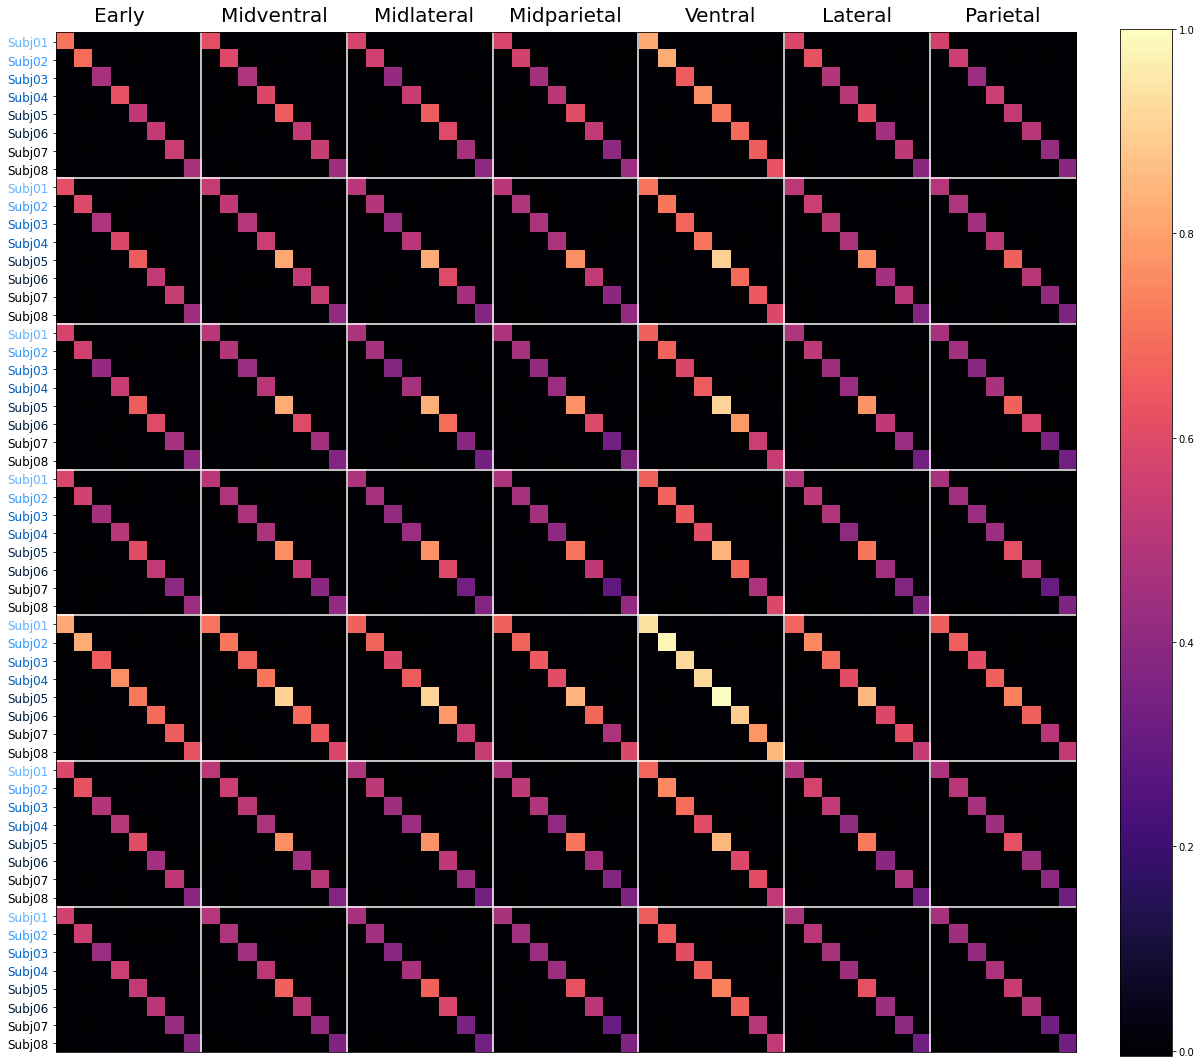

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix_no_corr_h1,
           cmap='magma')


y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks= np.array([3,11.5,19.75,27.5,36,43.5,51.5])
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 7), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(56):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=7.5, c='w')
plt.axvline(x=15.5, c='w')
plt.axvline(x=23.5, c='w')
plt.axvline(x=31.5, c='w')
plt.axvline(x=39.5, c='w')
plt.axvline(x=47.5, c='w')

plt.axhline(y=7.5, c='w')
plt.axhline(y=15.5, c='w')
plt.axhline(y=23.5, c='w')
plt.axhline(y=31.5, c='w')
plt.axhline(y=39.5, c='w')
plt.axhline(y=47.5, c='w')

#plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

### Hypothesis 2: Hierarchy


In [16]:
signal = np.zeros((len(ROI_names)-1,flat_rsm_length))
case_signal = np.zeros((len(subjid),len(ROI_names)-1,flat_rsm_length, n_repeats))


#signalsd[0] = np.random.rand(1,1)
#signalsd[1:4] = np.random.rand(1,1)
#signalsd[4:7] = np.random.rand(1,1)

signal[0,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)
signal[1:4,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)
signal[4:7,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)


for sidx, subj in enumerate(subjid):
    
    for r in range(0,len(ROI_names)-1):
        
        noisesd = (1-rr_norm[sidx,r])*1.6 #np.random.rand(1,1)
        #case_signal[sidx, r, :] = signal[sidx,:] + noisesd[sidx] * ((np.random.rand(1, flat_rsm_length) * 2)-1)
        for rep in range(0,n_repeats):
            #case_signal[sidx, r, :, rep] = signal[sidx,:] + ((np.random.rand(1, flat_rsm_length) * 2)-1)
            case_signal[sidx, r, :, rep] = signal[r,:] + noisesd * ((np.random.rand(1, flat_rsm_length) * 2)-1)

In [17]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix_h2 = np.zeros((total_combs,total_combs))
mega_matrix_no_corr_h2 = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,1],case_signal[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    #split_half_model = stats.pearsonr(case_signal[sidx1,roi_idx1,:],case_signal[sidx1,roi_idx1,:])[0]
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,1],case_signal[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        #split_half_target = stats.pearsonr(case_signal[sidx2,roi_idx2,:],case_signal[sidx2,roi_idx2,:])[0]
        
        #rsm_corr = stats.pearsonr(case_signal[sidx1,roi_idx1,:],
        #                          case_signal[sidx2,roi_idx2,:])[0]
        #mega_matrix[i,j] = rsm_corr #/ (np.sqrt(split_half_model) * np.sqrt(split_half_target)) 
                      
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix_h2[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h2[i,j] = np.mean(rsm_corr) 
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix_h2[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h2[i,j] = np.mean(rsm_corr) 
        

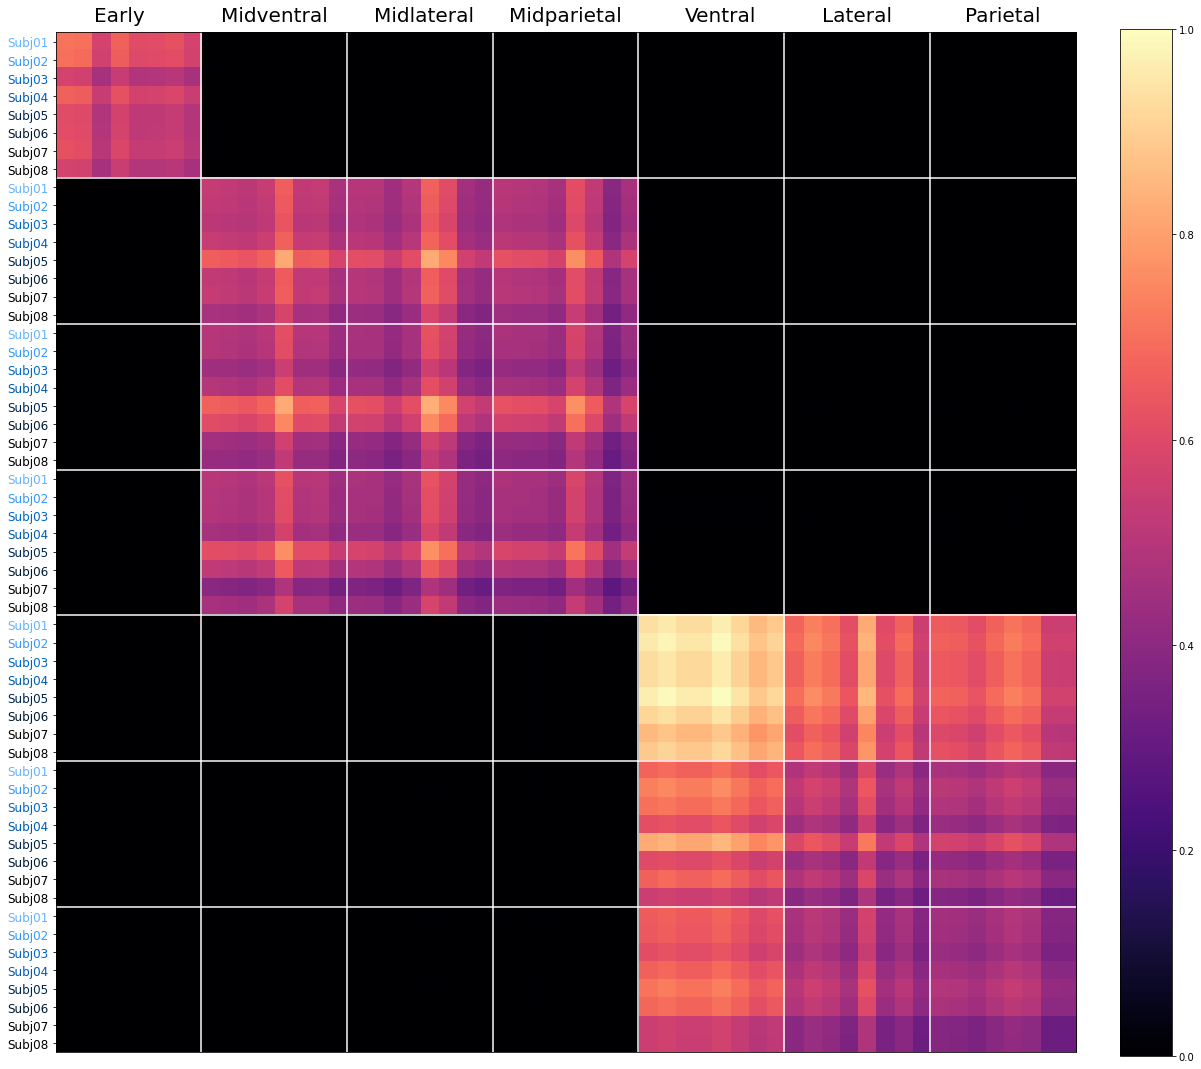

In [18]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix_no_corr_h2,
           cmap='magma')


y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks= np.array([3,11.5,19.75,27.5,36,43.5,51.5])
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 7), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(56):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=7.5, c='w')
plt.axvline(x=15.5, c='w')
plt.axvline(x=23.5, c='w')
plt.axvline(x=31.5, c='w')
plt.axvline(x=39.5, c='w')
plt.axvline(x=47.5, c='w')

plt.axhline(y=7.5, c='w')
plt.axhline(y=15.5, c='w')
plt.axhline(y=23.5, c='w')
plt.axhline(y=31.5, c='w')
plt.axhline(y=39.5, c='w')
plt.axhline(y=47.5, c='w')

plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

### Hypothesis 3: Two streams

In [19]:
signal = np.zeros((len(ROI_names)-1,flat_rsm_length))
case_signal = np.zeros((len(subjid),len(ROI_names)-1,flat_rsm_length, n_repeats))

signal[0,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)
dorsalsig = ((np.random.rand(1, flat_rsm_length) * 2)-1)
ventralsig = ((np.random.rand(1, flat_rsm_length) * 2)-1)
signal[1:3,:] = ventralsig
signal[4:6,:] = ventralsig
signal[3,:] = dorsalsig
signal[6,:] = dorsalsig


for sidx, subj in enumerate(subjid):
    
    for r in range(0,len(ROI_names)-1):
        
        #noisesd = np.random.rand(1,1)*1.1
        noisesd = (1-rr_norm[sidx,r])*1.6 #make noise match actual reliabilities
        #case_signal[sidx, r, :] = signal[sidx,:] + noisesd[sidx] * ((np.random.rand(1, flat_rsm_length) * 2)-1)
        for rep in range(0,n_repeats):
            #case_signal[sidx, r, :, rep] = signal[sidx,:] + ((np.random.rand(1, flat_rsm_length) * 2)-1)
            case_signal[sidx, r, :, rep] = signal[r,:] + noisesd * ((np.random.rand(1, flat_rsm_length) * 2)-1)

In [20]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix_h3 = np.zeros((total_combs,total_combs))
mega_matrix_no_corr_h3 = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,1],case_signal[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    #split_half_model = stats.pearsonr(case_signal[sidx1,roi_idx1,:],case_signal[sidx1,roi_idx1,:])[0]
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,1],case_signal[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        #split_half_target = stats.pearsonr(case_signal[sidx2,roi_idx2,:],case_signal[sidx2,roi_idx2,:])[0]
        
        #rsm_corr = stats.pearsonr(case_signal[sidx1,roi_idx1,:],
        #                          case_signal[sidx2,roi_idx2,:])[0]
        #mega_matrix[i,j] = rsm_corr #/ (np.sqrt(split_half_model) * np.sqrt(split_half_target)) 
                      
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix_h3[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h3[i,j] = np.mean(rsm_corr) 
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix_h3[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h3[i,j] = np.mean(rsm_corr) 
        

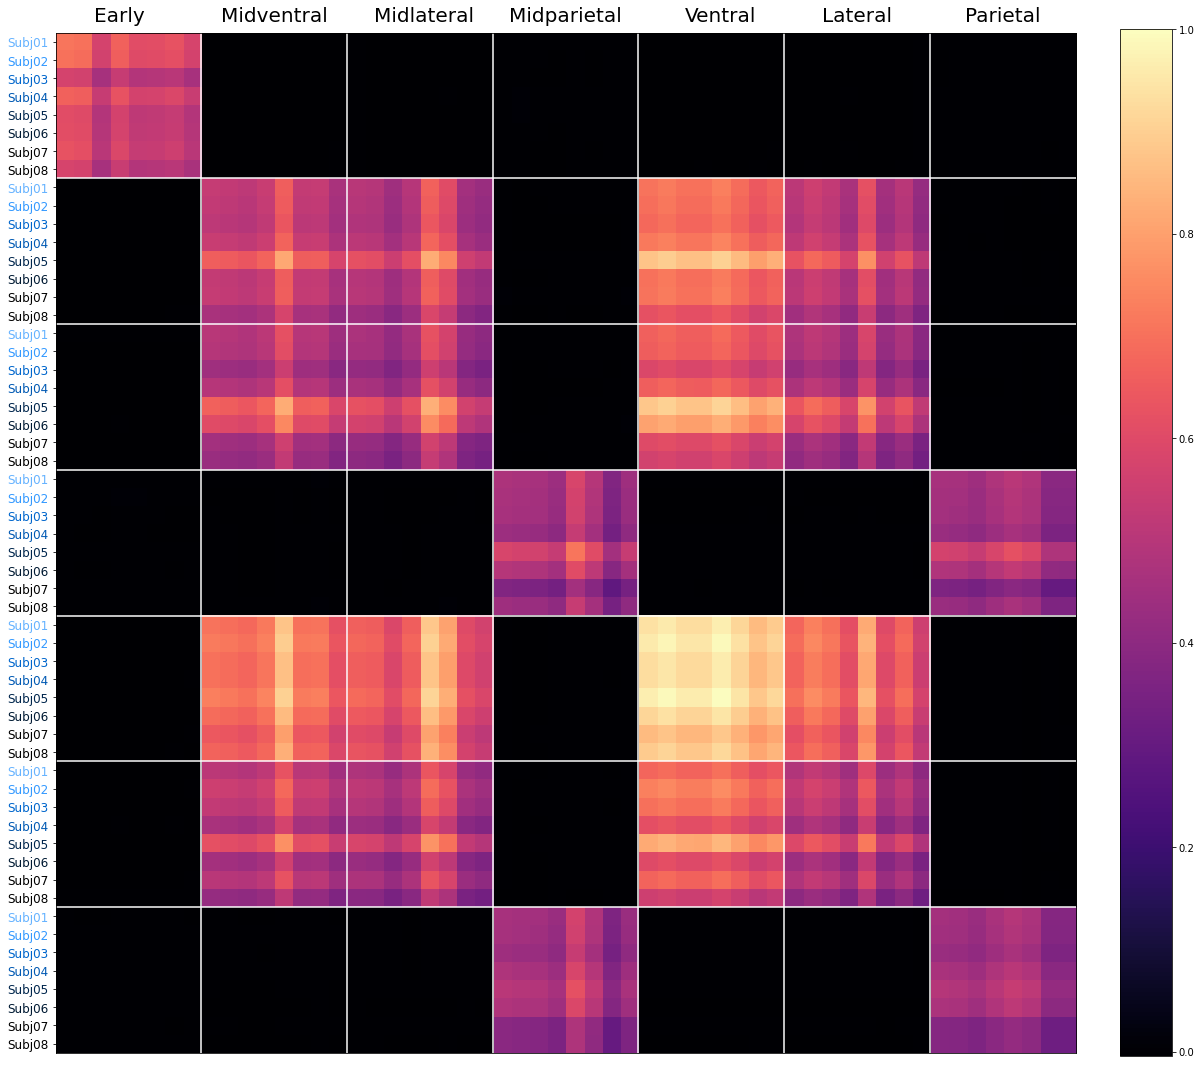

In [21]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix_no_corr_h3,
           cmap='magma')


y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks= np.array([3,11.5,19.75,27.5,36,43.5,51.5])
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 7), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(56):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=7.5, c='w')
plt.axvline(x=15.5, c='w')
plt.axvline(x=23.5, c='w')
plt.axvline(x=31.5, c='w')
plt.axvline(x=39.5, c='w')
plt.axvline(x=47.5, c='w')

plt.axhline(y=7.5, c='w')
plt.axhline(y=15.5, c='w')
plt.axhline(y=23.5, c='w')
plt.axhline(y=31.5, c='w')
plt.axhline(y=39.5, c='w')
plt.axhline(y=47.5, c='w')

#plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

### Hypothesis 4: Three streams


In [22]:
ignalsd = np.zeros((len(ROI_names)-1))
signal = np.zeros((len(ROI_names)-1,flat_rsm_length))
case_signal = np.zeros((len(subjid),len(ROI_names)-1,flat_rsm_length, n_repeats))


signal[0,:] = ((np.random.rand(1, flat_rsm_length) * 2)-1)
dorsalsig = ((np.random.rand(1, flat_rsm_length) * 2)-1)
lateralsig = ((np.random.rand(1, flat_rsm_length) * 2)-1)
ventralsig = ((np.random.rand(1, flat_rsm_length) * 2)-1)
signal[1,:] = ventralsig
signal[4,:] = ventralsig
signal[2,:] = lateralsig
signal[5,:] = lateralsig
signal[3,:] = dorsalsig
signal[6,:] = dorsalsig


for sidx, subj in enumerate(subjid):
    
    for r in range(0,len(ROI_names)-1):
        
        #noisesd = np.random.rand(1,1)*1.1
        noisesd = (1-rr_norm[sidx,r])*1.6 #make noise match actual reliabilities
        #case_signal[sidx, r, :] = signal[sidx,:] + noisesd[sidx] * ((np.random.rand(1, flat_rsm_length) * 2)-1)
        for rep in range(0,n_repeats):
            #case_signal[sidx, r, :, rep] = signal[sidx,:] + ((np.random.rand(1, flat_rsm_length) * 2)-1)
            case_signal[sidx, r, :, rep] = signal[r,:] + noisesd * ((np.random.rand(1, flat_rsm_length) * 2)-1)

In [23]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix_h4 = np.zeros((total_combs,total_combs))
mega_matrix_no_corr_h4 = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,0],case_signal[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(case_signal[sidx1,roi_idx1,:,1],case_signal[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    #split_half_model = stats.pearsonr(case_signal[sidx1,roi_idx1,:],case_signal[sidx1,roi_idx1,:])[0]
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,0],case_signal[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(case_signal[sidx2,roi_idx2,:,1],case_signal[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        #split_half_target = stats.pearsonr(case_signal[sidx2,roi_idx2,:],case_signal[sidx2,roi_idx2,:])[0]
        
        #rsm_corr = stats.pearsonr(case_signal[sidx1,roi_idx1,:],
        #                          case_signal[sidx2,roi_idx2,:])[0]
        #mega_matrix[i,j] = rsm_corr #/ (np.sqrt(split_half_model) * np.sqrt(split_half_target)) 
                      
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix_h4[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h4[i,j] = np.mean(rsm_corr) 
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(case_signal[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             case_signal[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix_h4[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
            mega_matrix_no_corr_h4[i,j] = np.mean(rsm_corr) 
        

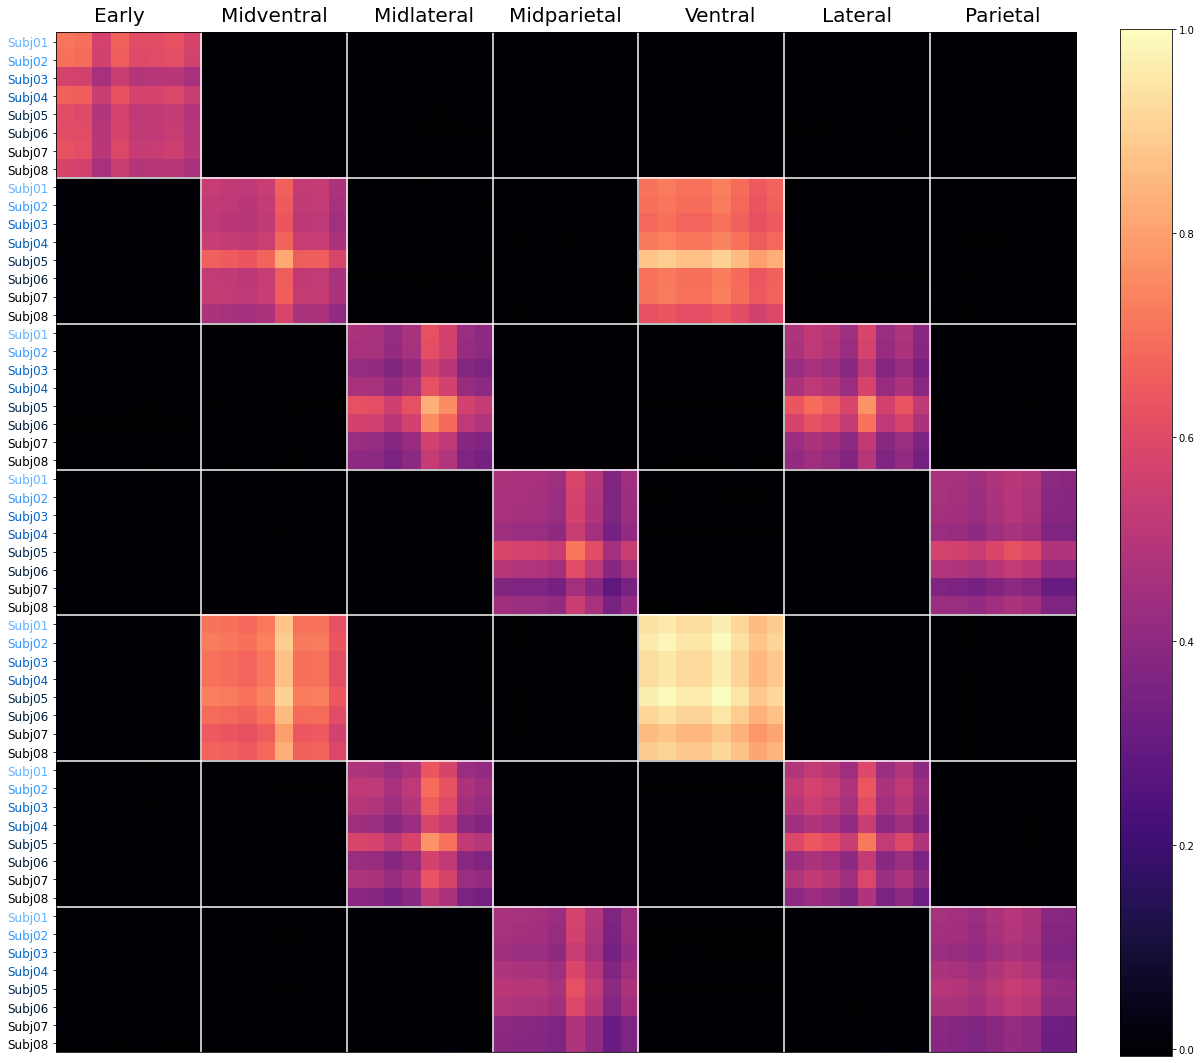

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix_no_corr_h4,
           cmap='magma')


y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks= np.array([3,11.5,19.75,27.5,36,43.5,51.5])
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 7), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(56):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=7.5, c='w')
plt.axvline(x=15.5, c='w')
plt.axvline(x=23.5, c='w')
plt.axvline(x=31.5, c='w')
plt.axvline(x=39.5, c='w')
plt.axvline(x=47.5, c='w')

plt.axhline(y=7.5, c='w')
plt.axhline(y=15.5, c='w')
plt.axhline(y=23.5, c='w')
plt.axhline(y=31.5, c='w')
plt.axhline(y=39.5, c='w')
plt.axhline(y=47.5, c='w')

#plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

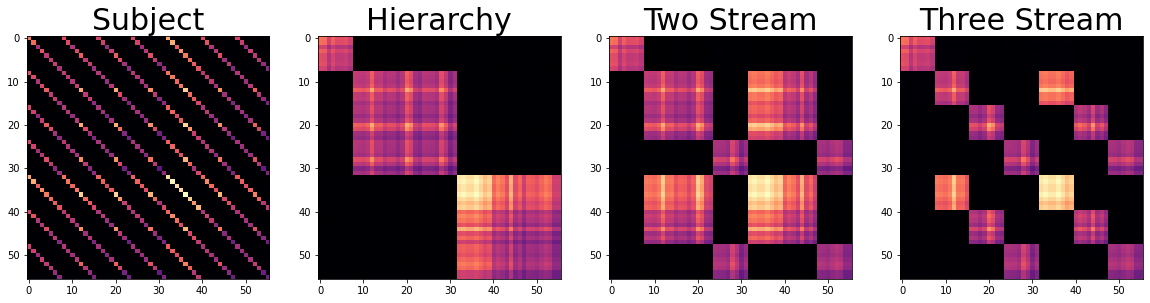

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,10))

ax1.imshow(mega_matrix_no_corr_h1,
           cmap='magma')
ax1.set_title('Subject', fontsize=30)
ax2.imshow(mega_matrix_no_corr_h2,
           cmap='magma')
ax2.set_title('Hierarchy', fontsize=30)
ax3.imshow(mega_matrix_no_corr_h3,
           cmap='magma')
ax3.set_title('Two Stream', fontsize=30)
ax4.imshow(mega_matrix_no_corr_h4,
           cmap='magma')
ax4.set_title('Three Stream', fontsize=30)

plt.show()

fig.savefig('../../../results/figures/simulation_one_hemi_no_corr.png')

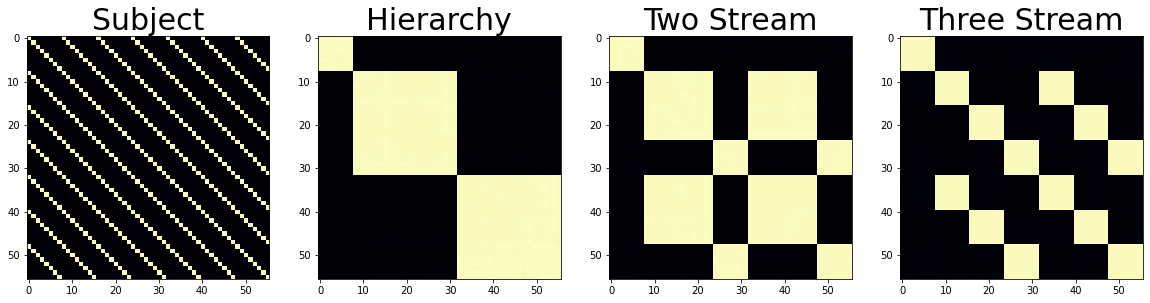

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,10))

ax1.imshow(mega_matrix_h1,
           cmap='magma')
ax1.set_title('Subject', fontsize=30)
ax2.imshow(mega_matrix_h2,
           cmap='magma')
ax2.set_title('Hierarchy', fontsize=30)
ax3.imshow(mega_matrix_h3,
           cmap='magma')
ax3.set_title('Two Stream', fontsize=30)
ax4.imshow(mega_matrix_h4,
           cmap='magma')
ax4.set_title('Three Stream', fontsize=30)

plt.show()

fig.savefig('../../../results/figures/simulation_one_hemi.png')

In [27]:
mega_matrix_h1

array([[ 1.00000000e+00,  3.20523892e-03,  1.72529233e-03, ...,
         1.98169991e-03,  1.78405965e-03, -1.66753098e-03],
       [ 3.20523892e-03,  1.00000000e+00,  1.05286940e-03, ...,
        -2.53019564e-04, -4.49479426e-03, -1.37462377e-03],
       [ 1.72529233e-03,  1.05286940e-03,  1.00000000e+00, ...,
         2.54904730e-03, -5.44060821e-04,  1.14827490e-02],
       ...,
       [ 1.98169991e-03, -2.53019564e-04,  2.54904730e-03, ...,
         1.00000000e+00, -1.89383447e-03, -1.36977873e-03],
       [ 1.78405965e-03, -4.49479426e-03, -5.44060821e-04, ...,
        -1.89383447e-03,  1.00000000e+00,  8.43253386e-03],
       [-1.66753098e-03, -1.37462377e-03,  1.14827490e-02, ...,
        -1.36977873e-03,  8.43253386e-03,  1.00000000e+00]])